In [39]:
import pandas as pd

df = pd.read_csv("./data/student_lifestyle_dataset.csv")
df.head()
df.shape

df['Stress_Level'] = df['Stress_Level'].map({
    'Low': 1,
    'Moderate': 2,
    'High': 3
})


#Here we are shown the results for the t-tests, p-values, R squared, and confidence intervals

#Now we check for collinearity using VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

# VIF > 5 = MODERATE. IF VIF > 10, SERIOUS
# SLEEP -> HIGH
# STUDY -> HIGH
# PHYS, EXT, SOC, -> acpt.
#SLEEP AND STUDY ARE STRONGLY RELATED


# SSR = 372.7586
# RM SSR 372.9720, DIFF = 0.2133
# FSTAT = 0.5707
# PVAL = 0.5652
# Therefore, exercise, extracurriculars, and social hours do NOT improve prediction, indicating they are NOT statistically significant.


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1997.0,372.971969,0.0,NaN,NaN,NaN
1,1995.0,372.758693,2.0,0.213276,0.570725,0.565208


In [40]:
#check
import statsmodels.api as sm

X = df[['Sleep_Hours_Per_Day', 'Study_Hours_Per_Day','GPA', 'Physical_Activity_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Social_Hours_Per_Day']]
y = df['Stress_Level']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Stress_Level   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     733.2
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:35:36   Log-Likelihood:                -1157.9
No. Observations:                2000   AIC:                             2328.
Df Residuals:                    1994   BIC:                             2361.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Sleep_Hour

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,Feature,VIF
0,Sleep_Hours_Per_Day,25.454476
1,Study_Hours_Per_Day,97.244827
2,GPA,2.178496
3,Physical_Activity_Hours_Per_Day,7.313372
4,Extracurricular_Hours_Per_Day,4.593235
5,Social_Hours_Per_Day,4.973264


In [49]:
#MUST USE TWO OLS
import statsmodels.api as sm
X_full = df[['Sleep_Hours_Per_Day',
             'Study_Hours_Per_Day',
             'Physical_Activity_Hours_Per_Day',
             'Social_Hours_Per_Day',
             'GPA']]
X_full = sm.add_constant(X_full)
full = sm.OLS(y, X_full).fit()
#if either Sleep Hours per day or study hours per day is missing from this model then the p value becomes extremely small
X_reduced = df[['Sleep_Hours_Per_Day','Study_Hours_Per_Day']]
X_reduced = sm.add_constant(X_reduced)
reduced = sm.OLS(y, X_reduced).fit()

from statsmodels.stats.anova import anova_lm
anova_lm(reduced, full)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1997.0,372.971969,0.0,NaN,NaN,NaN
1,1994.0,372.758620,3.0,0.213349,0.380422,0.767132


                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     1172.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:53:28   Log-Likelihood:                 355.99
No. Observations:                2000   AIC:                            -706.0
Df Residuals:                    1997   BIC:                            -689.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9999    

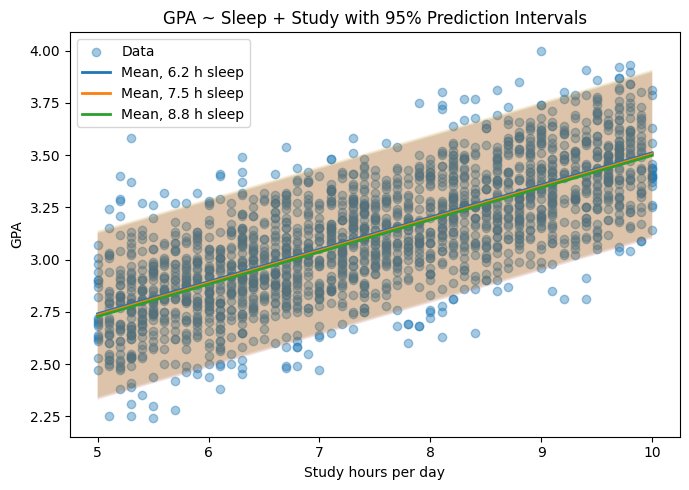

In [57]:
import statsmodels.formula.api as smf

m = smf.ols(
    "GPA ~ Sleep_Hours_Per_Day + Study_Hours_Per_Day",
    data=df
).fit()
print(m.summary())

sleep_vals = np.quantile(df["Sleep_Hours_Per_Day"], [0.25, 0.5, 0.75])

study_min = df["Study_Hours_Per_Day"].min()
study_max = df["Study_Hours_Per_Day"].max()
study_grid = np.linspace(study_min, study_max, 100)

rows = []
for s in sleep_vals:
    for st in study_grid:
        rows.append({
            "Sleep_Hours_Per_Day": s,
            "Study_Hours_Per_Day": st,
            "Sleep_label": f"{s:.1f} h sleep"
        })

grid = pd.DataFrame(rows)
pred = m.get_prediction(grid)
pred_sf = pred.summary_frame(alpha=0.05)  # 95% intervals

# Merge back for plotting
grid["mean"]          = pred_sf["mean"]
grid["pi_lower"]      = pred_sf["obs_ci_lower"]   # prediction interval
grid["pi_upper"]      = pred_sf["obs_ci_upper"]
grid["mean_ci_lower"] = pred_sf["mean_ci_lower"]  # (optional) CI for mean
grid["mean_ci_upper"] = pred_sf["mean_ci_upper"]
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

# Raw data scatter for reference
plt.scatter(
    df["Study_Hours_Per_Day"],
    df["GPA"],
    alpha=0.4,
    label="Data"
)

for label, g in grid.groupby("Sleep_label"):
    # Fitted mean line
    plt.plot(
        g["Study_Hours_Per_Day"],
        g["mean"],
        linewidth=2,
        label=f"Mean, {label}"
    )

    # Prediction interval band
    plt.fill_between(
        g["Study_Hours_Per_Day"],
        g["pi_lower"],
        g["pi_upper"],
        alpha=0.15
    )

plt.xlabel("Study hours per day")
plt.ylabel("GPA")
plt.title("GPA ~ Sleep + Study with 95% Prediction Intervals")
plt.legend()
plt.tight_layout()
plt.show()



In [50]:
X_full = df[['Sleep_Hours_Per_Day', 'Study_Hours_Per_Day',
        'GPA', 'Physical_Activity_Hours_Per_Day',
        'Social_Hours_Per_Day']]
X_restricted = df[['Sleep_Hours_Per_Day', 'Study_Hours_Per_Day',
        'GPA']]
model_full = OrderedModel(y, X_full).fit().summary()
model_restricted = OrderedModel(y, X_restricted).fit().summary()
print(model_full)
print(model_restricted)

Optimization terminated successfully.
         Current function value: 0.469802
         Iterations: 492
         Function evaluations: 790
                             OrderedModel Results                             
Dep. Variable:           Stress_Level   Log-Likelihood:                -965.41
Model:                   OrderedModel   AIC:                             1945.
Method:            Maximum Likelihood   BIC:                             1984.
Date:                Sat, 29 Nov 2025                                         
Time:                        19:38:19                                         
No. Observations:                2000                                         
Df Residuals:                    1993                                         
Df Model:                           5                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

/home/nor/Projects/LinearLegends/.venv/lib64/python3.13/site-packages/statsmodels/base/optimizer.py:748: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/nor/Projects/LinearLegends/.venv/lib64/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.469802
         Iterations: 492
         Function evaluations: 790
Predicted    0    1    2
Actual                  
1          206   91    0
2           49  470  155
3            0  140  889


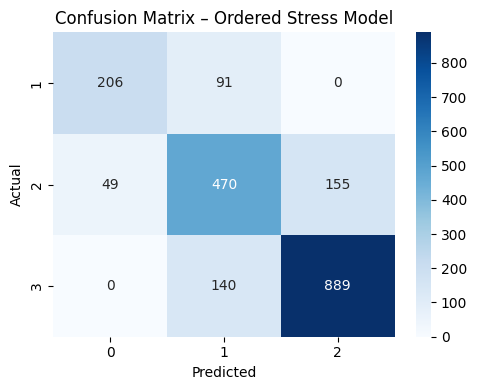

In [54]:
probs = OrderedModel(y, X_restricted).fit().predict(X_restricted)
y_pred = probs.idxmax(axis=1)
cm = pd.crosstab(
    y,          # actual
    y_pred,     # predicted
    rownames=['Actual'],
    colnames=['Predicted']
)
print(cm)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix – Ordered Stress Model")
plt.tight_layout()
plt.show()